In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import os

In [2]:
import geoplot
import geoplot.crs as gcrs
import folium
import contextily as cx

In [3]:
import pyproj
from osgeo import gdal
from shapely.geometry import LineString, Point

In [4]:
# Load cleaned Utrecht data
df = pd.read_csv('C:/Users/Jiatong/Documents/Air Pollution Project/utrechttripstime.csv',
                 sep = ";",
                 encoding = "ISO-8859-1")

In [5]:
df = df[df['VertUur'] != '#NULL!']

In [6]:
# Relevant socio-demographic factors
categories = ['OPID', 'HHPers', 'HHSam', 'WoPC', 'Sted', 'GemGr', 'BuurtAdam', 
              'Geslacht', 'Leeftijd', 'Herkomst', 'BetWerk', 'OnbBez', 'MaatsPart', 'Opleiding']

# Relevant journey factors
# VertUur and VertMin for timestamp of journey
# VertPC and AankPC for origin and destination of journey
journey = ['OPID', 'VertPC', 'AankPC', 'VertUur', 'VertMin', 'Reisduur', 'Hvm']

# Subset into categories
factors = df[categories]
trip = df[journey]

# Subset journeys into 3 primary modes of transport
by_car = trip[trip['Hvm'] == 1]
by_foot = trip[trip['Hvm'] == 9]
by_bike = trip[trip['Hvm'] == 8]

In [7]:
# Mapfile location
mapfile_loc = "C:/Users/Jiatong/Documents/Air Pollution Project/Data/Mapfiles/"

# Postcode 4 for Utrecht
pc4 = gpd.read_file(mapfile_loc + 'netherlands-postcode-pc4.geojson')
pc4 = pc4.to_crs(epsg = 28992)

In [8]:
pc4['pc4_code'] = pd.to_numeric(pc4['pc4_code'], downcast='float')

In [9]:
pc4['centroid'] = pc4.geometry.centroid

In [13]:
trip['Hvm'].value_counts()

8     1084
2      934
1      899
9      589
3      156
7       67
11      22
4       13
18      11
5       11
16      11
21       9
17       4
10       2
14       2
Name: Hvm, dtype: int64

In [11]:
pc4.to_csv('postcode4centroid.csv')

In [17]:
import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)

# get a graph
G = ox.graph_from_place('Utrecht, NL', network_type='bike')

C:\Users\Jiatong\miniconda3\envs\ssml\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


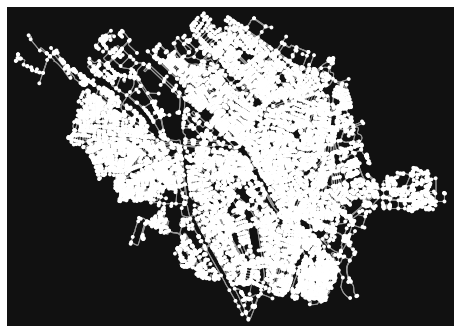

In [18]:
# Project graph
graph_proj = ox.project_graph(G, to_crs='epsg:28992')

# Plot graph
fig, ax = ox.plot_graph(graph_proj)

# Get Edges and Nodes
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [19]:
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame(geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

for index, row in trip.iterrows():
    origin = row['VertPC']
    target = row['AankPC']

    origin_cent = pc4.loc[pc4['pc4_code'] == origin].geometry.centroid
    target_cent = pc4.loc[pc4['pc4_code'] == target].geometry.centroid

    orig_node = ox.distance.nearest_nodes(graph_proj, origin_cent.x, origin_cent.y)
    target_node = ox.distance.nearest_nodes(graph_proj, target_cent.x, target_cent.y)
    
    try:
        route = nx.shortest_path(G=graph_proj, source = orig_node[0], target = target_node[0], weight='length')
        route_nodes = nodes_proj.loc[route]
        route_line = LineString(list(route_nodes.geometry.values))

        # Add a list of osmids associated with the route
        route_geom.loc[index] = [route_line]

    except:
        pass
    
route_geom['length_m'] = route_geom.length

In [20]:
trips = trip.join(route_geom, how='outer')

In [21]:
trips.to_csv('utrecht_bike.csv')
trips

,OPID,VertPC,AankPC,VertUur,VertMin,Reisduur,Hvm,geometry,length_m
2,56175178182,3525.0,3525.0,10,45,15,9,None,NaN
3,56175178182,3525.0,3525.0,13,15,5,8,None,NaN
4,56175178337,3512.0,3512.0,11,0,10,9,None,NaN
5,56175178337,3512.0,3512.0,13,0,10,9,None,NaN
6,56175178337,3512.0,3512.0,15,30,60,9,None,NaN
...,...,...,...,...,...,...,...,...,...
3934,62034168138,3514.0,3571.0,11,30,10,8,"LINESTRING (136832.261 457016.523, 136825.370 ...",1389.433167
3935,62034168138,3571.0,3722.0,17,0,20,1,"LINESTRING (137589.764 457844.396, 137543.155 ...",5675.713534
3937,62041521121,3524.0,3542.0,8,0,30,8,"LINESTRING (137848.351 452748.282, 137850.667 ...",9258.346475
3938,62041521121,3542.0,3524.0,18,30,30,8,"LINESTRING (132463.482 458598.521, 132723.758 ...",9269.752696


In [28]:
trips = pd.read_csv('utrecht_walk.csv')

In [26]:
cars = trips[trips['Hvm'] ==  9]

In [27]:
cars.to_csv('utr_cars_only.csv')

In [24]:
# Loop through postcode regions and find average NO2 values
times = range(9,21)
hour = 0


for postcodes in range(len(trip_gdf)):
    if trip_gdf.geometry.values[postcodes] != None:
        no2_value = item[item.intersects(trip_gdf.geometry.values[postcodes])]

        NO2 = np.average(no2_value.iloc[:,3])

        trip_gdf.loc[postcodes, str(times[hour]) + 'NO2_values'] = NO2

    else:
        pass

hour = hour + 1

In [30]:
trip_gdf.to_csv('.csv')

In [111]:
print(trip_gdf.loc[3934].geometry)

LINESTRING (136867.578014776 456968.3744153542, 136920.51084957307 456961.4950756069, 136937.79351763002 457107.483728739, 136962.26813157968 457117.08572465007, 136955.2267138019 457176.2238675333, 137014.10978903563 457191.63163391297, 137070.652075048 457205.9136745848, 137164.08012586908 457231.0231474834, 137210.9188147921 457243.09411279723, 137276.7135455298 457262.3966411692, 137284.46242149183 457279.6922783517, 137288.20913990377 457294.81034371594, 137299.0824926842 457316.055750782, 137383.54408224317 457278.76195410773, 137392.29124636762 457272.36690431926, 137418.84528332192 457265.97567848535, 137428.92538610208 457268.3877999257, 137444.39058123503 457296.0147760945, 137431.94208628012 457311.66853251396, 137427.59615333012 457367.3140346047, 137431.03659160453 457387.0283400782, 137450.8359662352 457441.2090030823, 137508.77591633098 457596.99197598116, 137523.91865338656 457636.6030794229, 137545.09542871552 457675.8370246259, 137538.1822702671 457683.46036471095, 13

In [112]:
trip_gdf

,OPID,VertPC,AankPC,VertUur,VertMin,Reisduur,Hvm,geometry,length_m
2,56175178182,3525.0,3525.0,10,45,15,9,None,NaN
3,56175178182,3525.0,3525.0,13,15,5,8,None,NaN
4,56175178337,3512.0,3512.0,11,0,10,9,None,NaN
5,56175178337,3512.0,3512.0,13,0,10,9,None,NaN
6,56175178337,3512.0,3512.0,15,30,60,9,None,NaN
...,...,...,...,...,...,...,...,...,...
3934,62034168138,3514.0,3571.0,11,30,10,8,"LINESTRING (136867.578 456968.374, 136920.511 ...",1483.787785
3935,62034168138,3571.0,3722.0,17,0,20,1,None,NaN
3937,62041521121,3524.0,3542.0,8,0,30,8,"LINESTRING (137848.351 452748.282, 137854.196 ...",10354.597316
3938,62041521121,3542.0,3524.0,18,30,30,8,"LINESTRING (132463.482 458598.521, 132723.758 ...",10325.869121
